In [1]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import os
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
# Input: 
path_load = '../03 outputs/recognizer.hdf5'
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
image_size = (150, 150)
path_train = '../01 data/train'
path_val = '../01 data/val'
path_test = '../01 data/val/glacier'

In [4]:
# load model
cnn = load_model(path_load)

In [5]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         2359424   
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                            
                                                                 
 dense_2 (Dense)             (None, 1, 1, 64)          8256      
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                      

In [15]:
def recognize_image(path, show_image=False):
    img = load_img(path, target_size=image_size)
    if show_image==True:
        plt.figure(figsize=(2,2))
        display = plt.imshow(img)
    img = img_to_array(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    result = cnn.predict(img, verbose=0)
    result = result.tolist()[0]
    pred = classes[result.index(max(result))]
    return result, pred

([1.0,
  0.3082100749015808,
  0.001374337705783546,
  5.450815354635097e-10,
  0.9942892789840698,
  0.9999964833259583],
 'buildings')

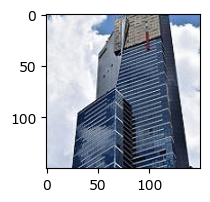

In [16]:
# Test single image prediction
recognize_image('../01 data/val/buildings/20057.jpg', True)

# Multiple predictions
## train

In [22]:
def multi_recognize_image_train(path, classes):
    file_name, true, pred, prob = [], [], [], []
    
    for folder in os.listdir(path):
        files = os.listdir(os.path.join(path, folder))
        for file in tqdm(files):
            result, prediction = recognize_image(os.path.join(path, folder, file))

            file_name.append(file)
            true.append(folder)
            pred.append(prediction)
            prob.append(result)
            
    output = pd.DataFrame({'file': file_name, 'true': true, 'pred': pred})
    
    output = pd.concat(
        [output, pd.DataFrame(prob, columns=classes)],
        axis=1
    )

    return output

In [24]:
pred_train = multi_recognize_image_train(path_train, classes)
print(pred_train.shape)
pred_train.head(3)

100%|██████████| 401/401 [01:49<00:00,  3.66it/s]

(2402, 9)


,file,true,pred,buildings,forest,glacier,mountain,sea,street
0,20060.jpg,buildings,buildings,1.0,0.735900,0.007252,0.002010,0.023442,0.999990
1,20061.jpg,buildings,buildings,1.0,0.083102,0.021933,0.735986,0.012722,0.999997
2,20073.jpg,buildings,buildings,1.0,0.000529,0.218249,0.000011,0.005768,0.998720


In [26]:
print('confusion_matrix')
print(pd.DataFrame(confusion_matrix(pred_train['true'], pred_train['pred']), index=classes))
print('')
print('Classification Report')
print(classification_report(pred_train['true'], pred_train['pred']))

confusion_matrix
             0    1    2    3    4    5
buildings  346    0    0    0    0    4
forest       1  378    0    0    1    0
glacier      0    0  421   18    3    1
mountain     0    0   20  397    3    0
sea          1    0    5    3  399    0
street     147    2    0    0    0  252

Classification Report
              precision    recall  f1-score   support

   buildings       0.70      0.99      0.82       350
      forest       0.99      0.99      0.99       380
     glacier       0.94      0.95      0.95       443
    mountain       0.95      0.95      0.95       420
         sea       0.98      0.98      0.98       408
      street       0.98      0.63      0.77       401

    accuracy                           0.91      2402
   macro avg       0.93      0.91      0.91      2402
weighted avg       0.93      0.91      0.91      2402



In [25]:
pred_train.to_csv('../03 outputs/pred_train.csv', index=False)

# val

In [ ]:
pred_val = multi_recognize_image_train(path_val, classes)
print(pred_val.shape)
pred_val.head(3)

In [ ]:
print('confusion_matrix')
print(pd.DataFrame(confusion_matrix(pred_val['true'], pred_val['pred']), index=classes))
print('')
print('Classification Report')
print(classification_report(pred_val['true'], pred_val['pred']))

In [ ]:
pred_val.to_csv('../03 outputs/pred_val.csv', index=False)

## test

In [27]:
def multi_recognize_image_test(path, classes):
    file_name, pred, prob = [], [], []
    
    files = os.listdir(path)[:20]
    for file in tqdm(files):
        result, prediction = recognize_image(os.path.join(path, file))

        file_name.append(file)
        pred.append(prediction)
        prob.append(result)
            
    output = pd.DataFrame({'file': file_name ,'pred': pred})
    
    output = pd.concat(
        [output, pd.DataFrame(prob, columns=classes)],
        axis=1
    )

    return output

In [30]:
pred_test = multi_recognize_image_test(path_test, classes)
print(pred_test.shape)
pred_test.head(3)

100%|██████████| 20/20 [00:05<00:00,  3.77it/s]

(20, 8)


,file,pred,buildings,forest,glacier,mountain,sea,street
0,20109.jpg,glacier,0.000278,0.001009,0.999127,0.993353,0.006733,0.002561
1,20187.jpg,glacier,0.000327,0.001890,0.998309,0.998174,0.137233,0.011266
2,20211.jpg,glacier,0.000052,0.000221,0.999997,0.996138,0.000321,0.000010


In [ ]:
pred_test.to_csv('../03 outputs/pred_test.csv', index=False)